<a href="https://colab.research.google.com/github/babeebird/DeepLearningfromScratch3/blob/main/%EC%A0%9C3%EA%B3%A0%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/deep-learning-from-scratch-3-master
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/deep-learning-from-scratch-3-master
/content/drive/MyDrive/deep-learning-from-scratch-3-master


In [2]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

# 제3고지.고차미분계산

#### step 25. 계산 그래프 시각화 (1) 
- Graphviz는 그래프(계산 그래프와 같이 노드,화살표로 이뤄진 데이터 구조)를 시각화해주는 도구.
- dot 명령 => dot sample.dot -T png -o sample.png
- 위 명령은 sample.dot 파일을 sample.png 로 변환 
- 옵션 -o 다음에 출력 '파일이름'을 지정하고, 옵션 -T 다음에 출력 파일의 '형식'을 지정 
- dot 입력파일이름 -T 파일형식 -o 출력파일이름 
- sample.dot 파일에는 그리려는 그래프의 내용이 DOT 언어로 쓰여 있는 것.
- DOT 언어는 그래프를 설명하는 언어로, 간단한 문법으로 그래프를 작성할 수 있음. 

##### DOT 언어 연습하기 
참고 - pg.214 그림 25-4 

```python
digraph g{
1 [label="x", color=orange, style=filled]
2 [label="y", color=orange, style=filled]
3 [label="Exp", color=lightblue, style=filled, shape=box]
1 -> 3
3 -> 2
}

```

In [4]:
import numpy as np
from dezero import Variable
from dezero.utils import get_dot_graph

In [5]:
#- step 26. 계산 그래프 시각화 (2)

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1 #- 어떤 계산

#- 변수 이름 지정
#- 계산 그래프를 시각화할 때 변수 노드에 레이블(이름)을 달아주는 것.
x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose=False)
#- get_dot_graph 함수에는 최종 출력인 변수 y를 인수로 제공
#- 출력 변수 y를 기점으로 한 계산 과정을 DOT 언어로 전환한 문자열을 반환
#- 역전파를 구현한 논리와 비슷! 

print(txt)

#- dot 파일로 저장
with open('sample.dot', 'w') as o:
  o.write(txt)

digraph g {
140566147246224 [label="y", color=orange, style=filled]
140566147246096 [label="Add", color=lightblue, style=filled, shape=box]
140566147246032 -> 140566147246096
140566147246160 -> 140566147246096
140566147246096 -> 140566147246224
140566147246032 [label="x0", color=orange, style=filled]
140566147246160 [label="x1", color=orange, style=filled]
}


360

In [6]:
def _dot_var(v, verbose=False): #- 보조 함수. 
#- 함수 이름 앞에 _가 붙은 이유? 이 함수를 로컬에서만 사용. get_dot_graph 전용으로 사용할 것 
  '''
  Args:
    v: Variable
    verbose: boolean 
             True이면 ndarray 인스턴스의 형상/타입도 함께 레이블로 출력
  Returns:
    DOT 언어로 작성된 문자열
    변수 Variable
  '''

  dot_var = '{} [label="{}", color=orange, style=filled]\n'

  name = '' if v.name is None else v.name 
  #- v.name이 None이면 공백을, None이 아니면 v.name을 할당 
  if verbose and v.data is not None: #- verbose가 True 이고, v.data가 None 이 아니라면
      if v.name is not None: #- v.name이 None 이 아니라면 
          name += ': '
      name += str(v.shape) + ' ' + str(v.dtype)

  return dot_var.format(id(v), name) 
  #- format 메서드는 문자열에 등장하는 "{}" 부분을 메서드 인수로 건넨 객체(문자열, 정수 등)으로 차례로 변환
  #- 변수 노드에 고유한 ID를 부여하기 위해 파이썬 내장함수 id() 사용
  #- id 함수는 주어진 객체의 고유한 ID를 반환.
  
#- 사용 예
x = Variable(np.random.randn(2,3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

140566147287120 [label="x", color=orange, style=filled]

140566147287120 [label="x: (2, 3) float64", color=orange, style=filled]



In [7]:
def _dot_func(f): #- 보조 함수 
#- DeZero 함수를 DOT 언어로 변환하는 편의 함수. 
#- 함수와 입력 변수의 관계, 함수와 출력 변수의 관계도 DOT언어로 기술
  
  '''
  Args:
    f : function 
  Returns:
    DOT 언어로 작성된 문자열
    함수, 함수와 입력 변수의 관계, 함수와 출력 변수의 관계
  '''

  # for function
  dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
  ret = dot_func.format(id(f), f.__class__.__name__)

  # for edge
  dot_edge = '{} -> {}\n'
  for x in f.inputs:
      ret += dot_edge.format(id(x), id(f))
  for y in f.outputs:  # y is weakref
      ret += dot_edge.format(id(f), id(y()))
  return ret

#- 사용 예
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

140566147331664 [label="Add", color=lightblue, style=filled, shape=box]
140566147331280 -> 140566147331664
140566147331536 -> 140566147331664
140566147331664 -> 140566147331600



In [8]:
def get_dot_graph(output, verbose=True): #- 메인 함수
  #- Variable 클래스의 backward 메서드와 거의 동일.
  #- 다만, backward 메서드는 미분값을 전파하지만, 여기서는 미분 대신 DOT 언어로 기술한 문자열을 txt에 추가
  
    """Generates a graphviz DOT text of a computational graph.
    Build a graph of functions and variables backward-reachable from the
    output. To visualize a graphviz DOT text, you need the dot binary from the
    graphviz package (www.graphviz.org).
    
    Args:
        output (dezero.Variable): Output variable from which the graph is
            constructed.
        verbose (bool): If True the dot graph contains additional information
            such as shapes and dtypes.
    Returns:
        str: A graphviz DOT text consisting of nodes and edges that are
            backward-reachable from the output
    """

    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f): 
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key=lambda x: x.generation)
            #- 실제 역전파와 달리 노드를 추적하는 순서는 문제가 되지 않으므로, 정렬 코드 주석처리! 
            #- 여기서는 '어떤 노드가 존재?" "어떤 노드와 연결?"이 중요.
            seen_set.add(f)

    add_func(output.creator) #- funcs에 output의 부모함수가 저장됨. 
    txt += _dot_var(output, verbose) #- 최종 출력변수

    while funcs: #- 역전파 시작
        func = funcs.pop()
        txt += _dot_func(func) #- 함수, 함수와 입력 변수의 관계, 함수와 출력 변수의 관계
        for x in func.inputs:
            txt += _dot_var(x, verbose) #- 함수의 입력변수

            if x.creator is not None:
                add_func(x.creator)

    return 'digraph g {\n' + txt + '}' #- 변수, 함수, 함수와 입력 변수의 관계, 함수와 출력 변수의 관계 


- os.path 는 일반적인 경로명 조작 모듈 
- os.path.exists(path) 는 path가 기존 경로나 열린 파일 기술자를 참조하면 True를 반환
- os.path.join(path, *paths) 는 하나 이상의 경로 구성 요소를 지능적으로 결합. 
  반환 값은 마지막을 제외한 path와 *paths의 모든 멤버에 대해 비어 있지 않은 각 부분 다음에 정확히 하나의 디렉터리 구분자가 오도록 이어붙인 것
- os.path.expanduser(path) 는 유닉스와 윈도우에서, ~나 ~user의 초기 구성 요소가 해당 사용자의 홈 디렉터리로 치환된 인자를 반환


In [9]:
import os 
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'): #- DOT 언어를 이미지로 변환
    dot_graph = get_dot_graph(output, verbose) 

    #- 1.dot 데이터를 파일에 저장
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    #- 일시적인 디렉토리 경로를 변수 tmp_dir 에 ~/.dezero 로 저장
    if not os.path.exists(tmp_dir): #- ~/.dezero 디렉터리가 없다면 새로 생성
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot') 
    #- 그래프를 저장할 디렉토리 경로를 변수 graph_path에 ~/.dezero/tmp_graph.dot 으로 저장 

    with open(graph_path, 'w') as f:
        f.write(dot_graph)

    #- 2.dot 명령 호출
    extension = os.path.splitext(to_file)[1][1:]  # Extension(e.g. png, pdf)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file) #- CoMmanDline
    #- step25에서 살펴본 DOT 언어 형식 => dot {입력파일이름} -T {파일형식} -o {출력파일이름} 
    #- 위 명령은 sample.dot 파일을 sample.png 로 변환 
    subprocess.run(cmd, shell=True) #- 파이썬에서 외부 프로그램을 호출하기 위함
    #- subprocess 모듈은 새로운 프로세스를 생성하고, 그들의 입력/출력/에러 파이프에 연결하고, 반환 코드를 얻을 수 있도록 함
    #- subprocess.run()은 args가 기술하는 명령을 실행
    #- Setting the shell argument to a true value causes subprocess to spawn an intermediate shell process, and tell it to run the command. 
    #- In other words, using an intermediate shell means that variables, glob patterns, and other special shell features in the command string are processed before the command is run


    # Return the image as a Jupyter Image object, to be displayed in-line.
    '''
    try:
    실행할 코드
    except:
    예외가 발생했을 때 처리하는 코드
    '''
    try:
        from IPython import display #- Public API for display tools in IPython.
        return display.Image(filename=to_file) #- Create a PNG/JPEG/GIF image object given raw data.
    except:
        pass


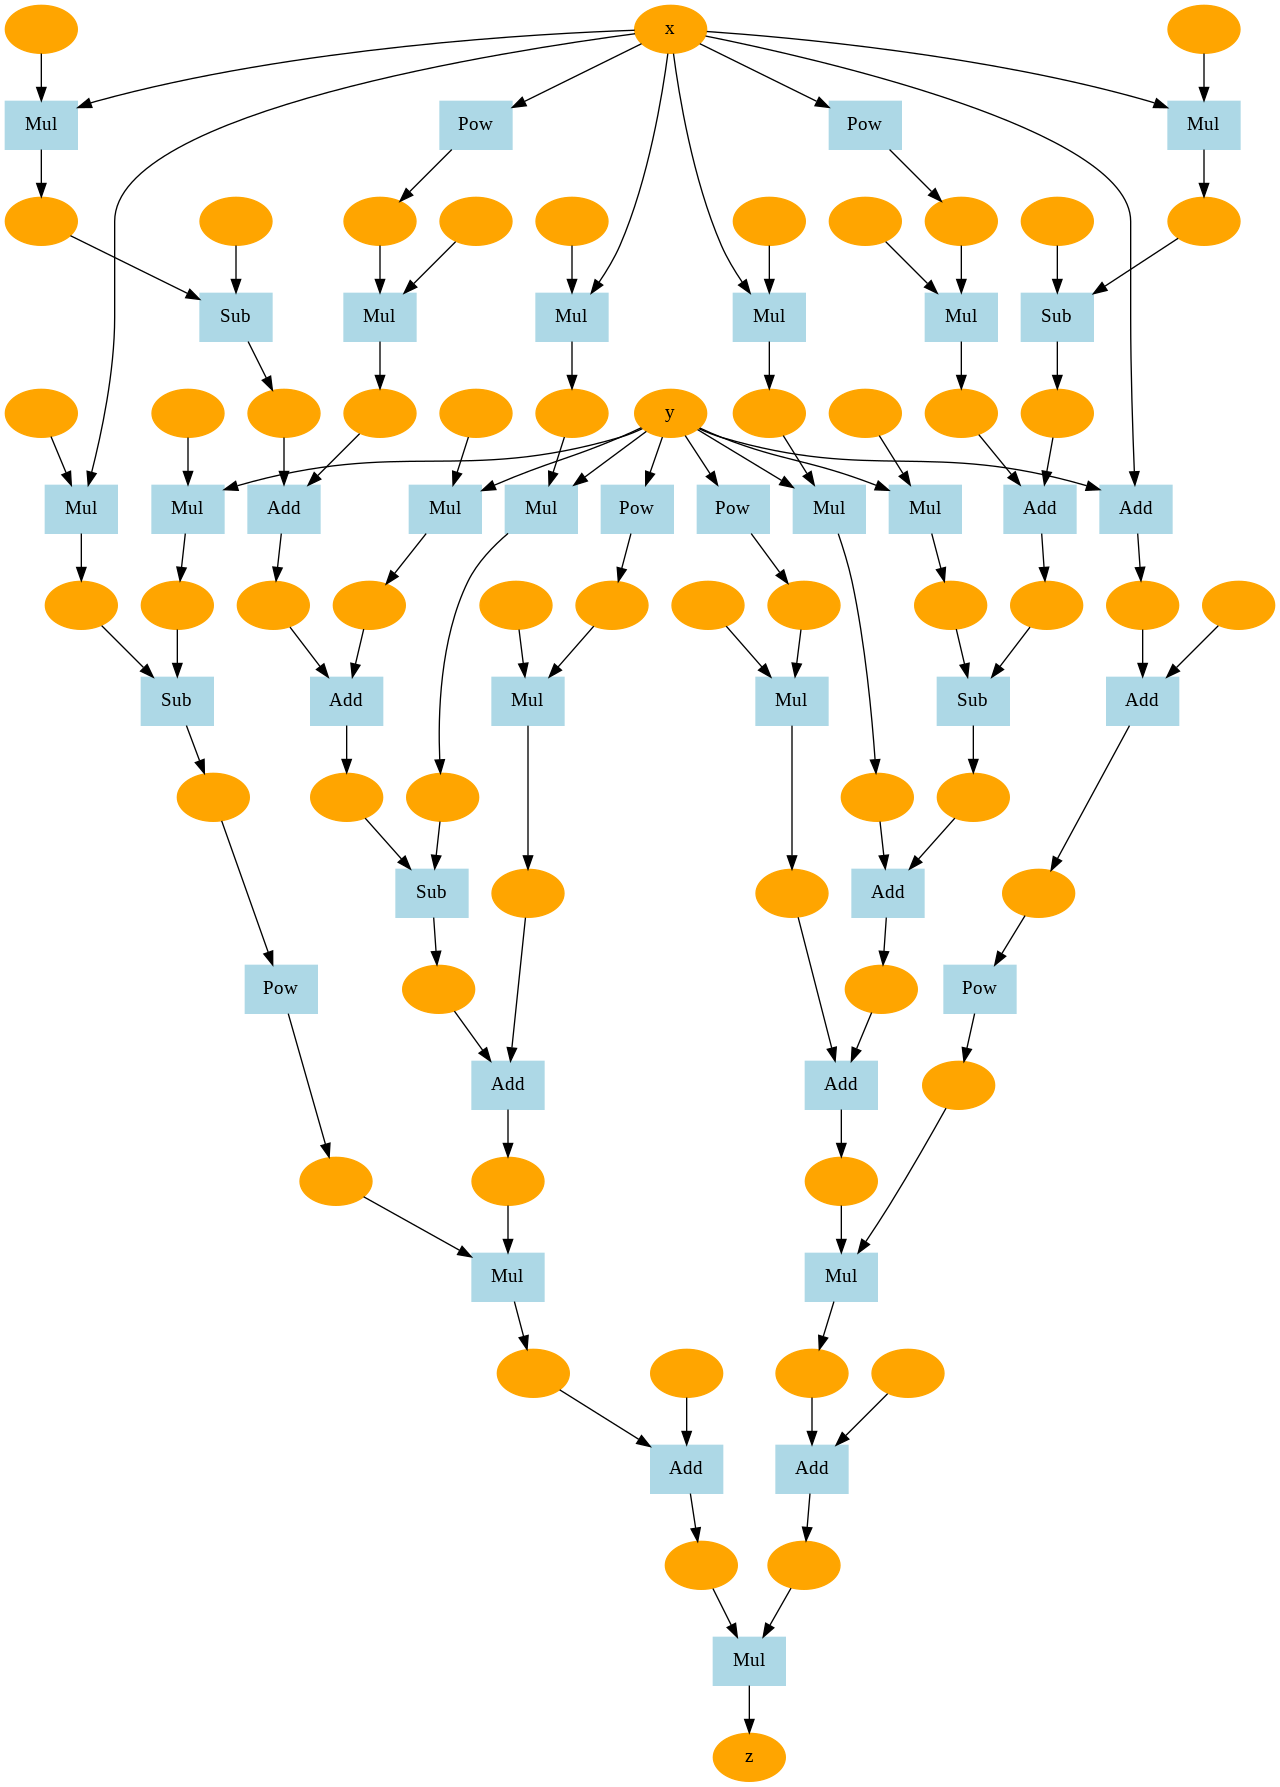

In [10]:
#- step.26.4 Goldstein-Price 함수 시각화 

def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png') #- goldstein.png 파일 생성

dezero와 고차미분  
- dezero는 복잡한 계산은 잘 하지만 아직 고차미분은 못한다
- 고차 미분이란 어떤 함수를 2번 이상 미분한 것
- 즉 역전파에 대한 역전파

  
상대경로와 절대경로
- 절대경로는 어떤 웹페이지나 파일이 가지고 있는 고유한 경로(주소) 
- 상대경로는 '현재 위치한 곳을 기준'으로 해서 '그곳의 위치'
  / : 루트
 ./ : 현재 위치
../ : 현재 위치의 상단 폴더

- 파일 경로를 표시할 때 명령 프롬프트 창에서는 /, \든 상관없지만, 소스코드 안에서는 반드시 / 또는 \\ 기호를 사용


--- original sin ---
0.7071067811865475
variable(0.7071067811865476)
--- approximate sin ---
0.7071064695751781
variable(0.7071032148228457)


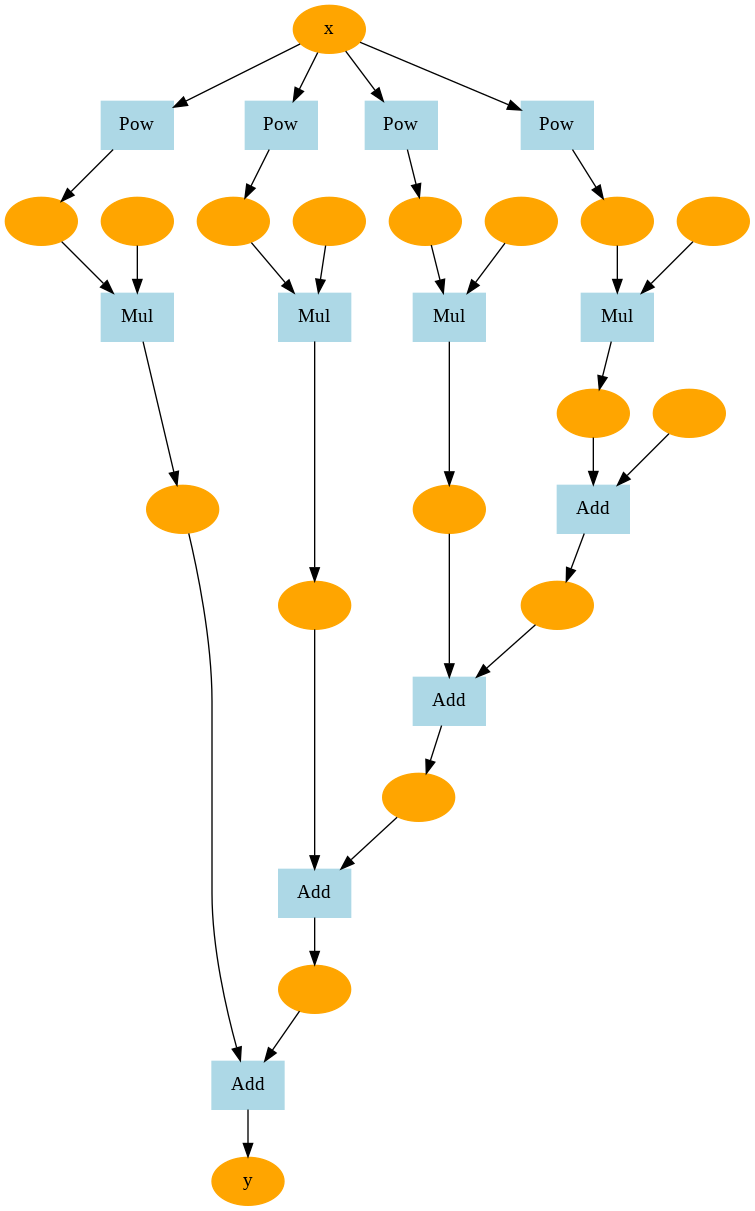

In [11]:
#- step 27. 테일러 급수(Taylor Series) 미분 
#- 테일러 급수란 어떤 함수를 다항식으로 근사하는 방법. 항이 많아질수록 근사의 정확도가 높아짐.
#- 목표 : sin 함수의 미분 
#- sin 함수의 해석적 미분값은 y=sin(x)일 때, dy/dx = cos(x)

if '__file__' in globals(): 
  #- globals 함수는 dict 데이터형으로 전역 변수들의 이름과 현재 값을 출력
  #- __file__ 은 현재 수행중인 코드를 담고 있는 파일의 위치한 Path를 의미 
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
    #- sys 모듈은 인터프리터에 의해 사용되거나 유지되는 일부 변수와 인터프리터와 강하게 상호 작용하는 함수에 대한 액세스를 제공
    #- 다시말하면 파이썬 인터프리터가 제공하는 변수와 함수를 직접 제어할 수 있게 해주는 것. 
    #- sys.path는 디렉터리의 경로들이 기록된 문자열 리스트. 자신이 만든 모듈 불러와 사용할 때 이용
    #- 이 리스트에 경로를 추가하면 해당 경로에 있는 파이썬 파일을 import 문으로 불러올 수 있음
    #- 이 책에서는 현재 실행파일의 상위 디렉토리에 직접 만든 모듈들이 저장되어 있다고 가정. 


import numpy as np
import math #- 이 모듈은 C 표준에서 정의된 수학 함수에 대한 액세스를 제공 << 여기서는 factorial 계산 시 활용
from dezero import Variable, Function
from dezero.utils import plot_dot_graph


class Sin(Function): #- Sin 클래스
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
      #- 해석적 미분 
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx


def sin(x): #- sin 함수
    return Sin()(x)


x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()
print('--- original sin ---')
#- 입력이 pi/4 일때 sin()과 cos()출력값이 같음 
print(y.data) 
print(x.grad) 


def my_sin(x, threshold=0.0001):
  #- pg.227 27.3 수식 참고
  #- 테일러 급수의 임곗값(threshold)을 작게 할수록 이론상으로 근사 정밀도가 좋아짐
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1) #- i 번째에 추가할 항목 
        y = y + t #시그마(합)를 이렇게 표현하는군요
        if abs(t.data) < threshold: #- t의 절댓값이 threshold보다 낮아지면, for문을 빠져나오자.
            break
    return y


x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # threshold=1e-150
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

In [12]:
#- step 28. 함수 최적화 by 미분 
#- 로젠브록 함수(바나나 함수) Rosenbrock function 의 최솟값 찾기 => pg.233 28.1 수식 참고
#- 로젠브록 함수는 최적화 문제의 벤치마크 함수로 자주 사용됨
#-  골짜기로 향하는 기울기에 비해 골짜기 바닥에서 전역 최솟값으로 가는 기울기가 너무 작아서 최적화가 어렵기에 
#- 최적화란 어떤 함수가 주어졌을 때 그 최솟값 또는 최댓값을 반환하는 입력을 찾는 일

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)
#- x0.grad, x1.grad 두 미분값을 모은 값 (-2.0, 400.0) 벡터를 기울기, 기울기 벡터 라고 함 
#- 기울기는 각 지점에서 함수의 출력을 가장 크게 하는 방향을 가리킴. 
#- 반대로 기울기에 마이너스를 곱한 (2.0, -400.0) 방향은 y값을 가장 작게 줄여주는 방향

variable(-2.0) variable(400.0)


In [13]:
#- 경사하강법, gradient descent
#- 복잡한 형상의 함수라면 기울기가 가리키는 방향에 반드시 최댓값(또는 최솟값)이 존재한다고 볼 수는 없음
#- 그러나 국소적으로는 기울기는 함수의 출력을 가장 크게 하는 방향을 나타냄. 
#- 기울기 방향으로 일정 거리만큼 이동하여 다시 기울기는 구하는 작업을 반복하면 점차 원하는 지점에 접근가능 => "경사하강법"

import numpy as np
from dezero import Variable
# import dezero's simple_core explicitly
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()


def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001 #- 학습률, learning rate
iters = 50000 #- 반복 횟수 << 경사하강법은 로젠브록 함수와 같이 골짜기가 길게 뻗은 함수에는 잘 대응하지 못함

for i in range(iters):
  #- 로젠브록 함수의 "최솟값" 찾기
  #- 로젠브록 함수 iter가 돌면서 1차 미분을 반복하는것! (고차미분수행이 아님) pg.242 그림 보면 이해 쉬움!   
    #- print(x0, x1)
    if iters - i < 6 :
      print(x0, x1)

    y = rosenbrock(x0, x1)

    #- for 문에서 x0, x1이라는 Variable 인스턴스를 반복 사용 => x0.grad, x1.grad에 미분값 누적됨 
    #- 역전파 전에 각 변수의 미분값을 초기화해야 함.
    x0.cleargrad() #- x0 미분값 초기화
    x1.cleargrad() #- x1 미분값 초기화
    y.backward() #- 역전파

    x0.data -= lr * x0.grad #- 기울기 방향에 마이너스를 곱한 방향으로 이동
    x1.data -= lr * x1.grad

variable(0.9999999993711475) variable(0.9999999987397786)
variable(0.9999999993713986) variable(0.9999999987402819)
variable(0.9999999993716496) variable(0.9999999987407849)
variable(0.9999999993719006) variable(0.9999999987412878)
variable(0.9999999993721514) variable(0.9999999987417905)


##### step 29. 뉴턴 방법으로 푸는 최적화(수동 계산)
- 갱신 횟수가 경사하강법보다 훨씬 적을 가능성이 있다

- 초깃값이 정답과 가까우면 더 빨리 수렴한다

---

- 뉴턴 방법으로 하려면 함수를 테일러 급수로 변환


- 2차 미분에서 중단해서 함수를 2차 함수로 근사

---

- 경사하강법: lr을 수동으로 조절, 1차 미분만 사용

- 뉴턴 방법은 lr을 자동으로 조절, 1,2차 미분 사용

In [14]:
#- step 29. 뉴턴 방법으로 푸는 최적화 (수동계산)
#- 경사하강법은 일반적으로 수렴이 느리다는 단점.
#- step28에서 로젠브록 함수의 최솟값을 경사하강법으로 구할때, 약 5만번 가량의 iteration 끝에 목적지 도달..
#- 뉴턴 방법은 경사하강법보다 수렴이 더 빠름! 6회 만에 목적지 도달! pg239, 29-1 참고
#- 테일러 급수에 따라 y=f(x) 변환. x=a를 기점으로 f를 x의 다항식으로 나타낸다.
#- 여기서는 2차 미분항까지 사용하여 근사하자. << y=f(x)는 어떤 함수를 x의 2차 함수로 근사. 
#- 근사한 2차함수는 x=a 에서 y=f(x)에 접하는 곡선. 
#- => 2차 함수의 해석적 미분을 통해 근사한 2차 함수의 최솟값 위치를 구할 수 있음. 
#- 최솟값의 위치는 x = a - f'(a)/f"(a) => a의 위치를 - f'(a)/f"(a) 만큼 갱신.
#- 갱신된 a의 위치에서 같은 작업 반복.

#- 경사하강법은 learning rate을 수동으로 설정하는 반면, 뉴턴방법은 "2차 미분"을 이용하여 자동으로 조절 
#- 경사하강법이 1차 미분만의 정보(속도)를 이용한다면, 뉴턴방법은 2차미분의 정보(가속도)까지 사용하는 것.
#- 뉴턴방법에서 lr 은 1/f"(x)


def f(x): 
    y = x ** 4 - 2 * x ** 2 #- 이 함수는 오목한 부분이 두 곳이며, 최솟값은 x=-1, x=1 인 위치 
    return y


def gx2(x): #- 수동 2차 미분
    return 12 * x ** 2 - 4


x = Variable(np.array(2.0)) #- 초깃값을 x=2 로 설정한 후, 최솟값 중 하나인 x=1에 도달할 수 있는지 검증해보자.
iters = 10

for i in range(iters):
    
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data) #- 뉴턴방법에서 lr 은 1/f"(x) 일때, f"(x) = gx2(x)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


#### step30.고차 미분 (준비편)
- DeZero는 미분을 자동으로 계산할 수 있지만, 아직까지는 1차 미분 한정..! 
- DeZero가 2,3,4 차 .. 형태의 고차미분을 자동으로 계산할 수 있다면 좋겠다!

- 계산의 연결은 Function 클래스의 __call__메서드에서 만들어짐 (순전파시 !!)
- 구체적인 순전파/역전파 계산은 Function 클래스를 상속한 클래스의 forward 메서드와 backward 메서드로 처리 

#### step31.고차 미분 (이론편)
- 미분값을 Variable 인스턴스 형태로 유지!
- 계산의 연결은 Function 클래스의 __call__메서드에서 만들어짐 (순전파시 !!) 
- Variable 인스턴스를 사용하여 순전파를 하는 시점에 연결이 만들어지는 것. 
- 문제 : 역전파 시에는 계산 그래프의 "연결" 이 만들어지지 않음.
- 미분계산을 계산그래프로 만들어보자! 
- How? **grad(미분값)를 Variable 인스턴스 형태로 유지**하자. 
  - (기존) ndrarray 인스턴스 참조 => (현재) Variable 인스턴스 참조
- pg.257 그림 31-3 에서 새로운 Variable 클래스(오른쪽)
  - x, gx는 Variable 인스턴스.
  - x, gx 내부의 data는 인스턴스 변수이자, ndarray 인스턴스.
  - x, gx 내부의 grad는 인스턴스 변수이자, Variable 인스턴스.
  - x.grad는 Variable 인스턴스인 gx를 참조. 

#### step32.고차 미분 (구현편)

- grad가 Variable 인스턴스 를 참조하도록
```python
class Variable:
  ...

  def backward(self, retain_grad=False):
    if self.grad is None:
      #- self.grad = np.ones_like(self.data)
      self.grad = Variable(np.ones_like(self.data)
``` 

- 함수 클래스의 역전파, backward 메서드
  - Add 클래스는 출력 쪽에서 전해지는 미분값을 입력 쪽으로 전달만 하기에, 수정할 것이 없음. 
  - Mul 클래스에서는 Variable 인스턴스 그대로 사용하도록
  ```python
  class Mul(Function):
    ...
    def backward(self, gy):
      """기존에는 ndarray 인스턴스인 input.data 를 사용
      x0 = self.inputs[0].data
      x1 = self.inputs[1].data
      """
      x0, x1 = self.inputs

      return gy * x1, gy * x0
    
    ```
    
    - 위 코드에서 gy, x1 모두 Variable 인스턴스
    - \* 연산자는 오버로드 되어있으므로, Mul 클래스의 순전파가 호출됨 => Mul()(gy, x1) 
    - 이어서 Function.\__call__()이 호출되고, 계산 그래프가 만들어짐. 


- 역전파를 효율적으로 하기위한 모드추가
  - step18 에서 역전파 비활성화 모드는 계산그래프 생성과 입력 변수 유지 등을 생략했음. 'enable_backprop' 
  - 역전파를 1회만 하는 경우, 역전파 계산에 "역전파 비활성 모드"를 실행하도록 하자. 



In [16]:
#- dezero/core.py 
import weakref #- 약한참조
import numpy as np
import contextlib
import dezero


class Config:
    enable_backprop = True
    train = True


@contextlib.contextmanager
def using_config(name, value): 
    old_value = getattr(Config, name) 
    #- getattr()는 object에 존재하는 속성의 값을 가져옴
    #- Config.name과 동일 
    setattr(Config, name, value)
    #- setattr()는 object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여한다.
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


def test_mode():
    return using_config('train', False)

try:
    import cupy
    array_types = (np.ndarray, cupy.ndarray) 
#- CuPy는 오픈소스 라이브러리로 NumPy 문법을 사용하며 NVIDIA GPU를 사용하여 행렬 연산으로 속도를 향상시킴 (NumPy는 GPU위에서의 계산을 지원하지 않음)
     
except ImportError:
    array_types = (np.ndarray)


class Variable: #- Variable 클래스 
    __array_priority__ = 200

    def __init__(self, data, name=None): #- 생성자 
      '''
      Args:
        data: ndarray
        name: string

      Returns: None
      '''
      if data is not None:
          if not isinstance(data, array_types):
              raise TypeError('{} is not supported'.format(type(data)))
      #- Variable 클래스의 인스턴스변수(속성)
      self.data = data #- 순전파 시 사용 (ndarray 인스턴스 저장)
      self.name = name
      self.grad = None #- 역전파 시 사용 (ndarray 인스턴스 저장)
      self.creator = None 
      self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def unchain(self):
        self.creator = None

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False):
      #- retain_grad가 True일 경우, 변수는 미분 결과를 메모리에 유지함(step18)
      #- create_graph=False 추가
      #- 대부분의 경우 역전파가 단 1회만 수행되는 경우가 대부분이기 때문에 default False
      #- 만약 2차 이상의 미분이 필요하다면 create_graph를 True로 설정 
        if self.grad is None: 
            xp = dezero.cuda.get_array_module(self.data)
            #- gpu 사용이 가능하면 cupy의 get_array_module을 변수 xp에 저장하여 반환하고
            #- gpu 사용이 불가능할 경우 numpy 모듈을 반환 
            self.grad = Variable(xp.ones_like(self.data)) #- self.grad 는 Variable 인스턴스를 담는다.
            #- self.grad에는 입력 데이터 self.data 의 형상이면서 1으로 초기화된 array가 Variable 타입으로 저장됨

#- CUDA("Compute Unified Device Architecture", 쿠다)
#- 그래픽 처리 장치(GPU)에서 수행하는 (병렬 처리) 알고리즘을 C 프로그래밍 언어를 비롯한 산업 표준 언어를 사용하여 작성할 수 있도록 하는 GPGPU 기술
#- 쿠다를 통해 개발자들은 쿠다 GPU 안 병렬 계산 요소 고유의 명령어 집합과 메모리에 접근할 수 있음.

        '''
        def get_array_module(x):
            """Returns the array module for `x`.
            Args:
                x (dezero.Variable or numpy.ndarray or cupy.ndarray): Values to
                    determine whether NumPy or CuPy should be used.
            Returns:
                module: `cupy` or `numpy` is returned based on the argument.
            """
            if isinstance(x, Variable):
                x = x.data

            if not gpu_enable:
                return np
            xp = cp.get_array_module(x)
            return xp
        '''


        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)
        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref

            '''
            class Config:
              enable_backprop = True
              train = True


            @contextlib.contextmanager
            def using_config(name, value): 
                old_value = getattr(Config, name) 
                #- getattr()는 object에 존재하는 속성의 값을 가져옴
                #- Config.name과 동일 
                setattr(Config, name, value)
                #- setattr()는 object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여한다.
                try:
                    yield
                finally:
                    setattr(Config, name, old_value)
              '''

            with using_config('enable_backprop', create_graph):
                #- with statement는 파이썬 v2.5 부터 생겼음
                #- with 는 __enter__ 를 실행시키고, 어떤 에러가 나더라도 __exit__() 를 반드시 실행시켜주는 역할
                #- try / finally 의 구문을 대체하기 위한 용도
                #- __enter__() 와 __exit__() 가 갖춰진 object 에 사용할 수 있음

                #- 여기서는 @contextlib.contextmanager 데코레이터를 활용.
                #- contextlib.contextmanager는 클래스나 별도의 __enter__()와 __exit__() 메서드를 작성할 필요 없이, 
                #-    with 문 컨텍스트 관리자를 위한 팩토리 함수를 정의하는 데 사용할 수 있는 데코레이터

                #- Config 클래스의 클래스변수 Config.enable_backprop의 default는 True임.
                #- 이때 using_config함수가 with 문으로 실행되면서, 
                #- with문 안에서는 Config.enable_backprop에 create_graph의 boolean 인스턴스가 참조됨. 
                #- create_graph의 default 값은 False 
                #- 왜냐면 실무에서는 역전파가 단 1회만 수행되는 경우가 대부분이기 때문. 
                #- 만약 2차 이상의 미분이 필요하다면 create_graph = True 로 설정 
              
                gxs = f.backward(*gys) #- 메인 backward 
                #- 함수의 backward 메서드에서 사용된 연산자는 오버로드 되어있음 
                #- 예를들어 Mul 클래스의 backward 메서드는 gy*x1 계산을 하는데,
                #- 여기서 *연산자는 오버로드 되어있기 때문에, 실제로는 Mul()(gy,x1) 코드가 호출됨
                #- 이어서 부모 클래스인 Function의 __call__()이 호출됨.
                #- __call__() 에서 Config.enable_backprop이 참조되며, 역전파 활성/비활성모드가 전환됨. 

                if not isinstance(gxs, tuple):
                    gxs = (gxs,)

                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        x.grad = x.grad + gx 

                    if x.creator is not None:
                        add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref

    def unchain_backward(self):
        if self.creator is not None:
            funcs = [self.creator]
            while funcs:
                f = funcs.pop()
                for x in f.inputs:
                    if x.creator is not None:
                        funcs.append(x.creator)
                        x.unchain()

    def reshape(self, *shape):
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return dezero.functions.reshape(self, shape)

    def transpose(self, *axes):
        if len(axes) == 0:
            axes = None
        elif len(axes) == 1:
            if isinstance(axes[0], (tuple, list)) or axes[0] is None:
                axes = axes[0]
        return dezero.functions.transpose(self, axes)

    @property
    def T(self):
        return dezero.functions.transpose(self)

    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)

    def to_cpu(self):
        if self.data is not None:
            self.data = dezero.cuda.as_numpy(self.data)

    def to_gpu(self):
        if self.data is not None:
            self.data = dezero.cuda.as_cupy(self.data)


class Parameter(Variable):
    pass


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x, array_module=np):
    if np.isscalar(x):
        return array_module.array(x)
    return x


class Function:
  #- 부모 클래스의 __call__ 메서드는 언제 호출 되는가 ? 
  #- 고차미분을 위해서는 y.backward() 호출 시 Function의 __call__이 호출되어야 한다? 
  #- pg.256 연산자 오버로드와도 연결시켜보면 ? pg.263 

    def __call__(self, *inputs): #- 객체의 함수화
      #- 호출 가능한 객체로 만들어주는 매직 메서드
      #- 함수를 호출하는 것처럼 클래스의 객체(인스턴스)도 호출하게 만들어주는 메서드.
      #- 객체가 호출이 가능한지 여부는 callable() 함수로 확인 가능.
      '''
      Args: 
        *inputs : Variable
      Returns:
        outputs if len(outputs) > 1 else outputs[0] : list or ndarray 
      '''
      inputs = [as_variable(x) for x in inputs] #- Variable을 요소로 하는 list

      xs = [x.data for x in inputs] 
      #- Variable 인스턴스 변수인 data를 꺼내어 xs에 모으기
      #- 순전파 시 입력

      ys = self.forward(*xs) #- 인스턴스 메서드 forward 호출, 순전파. 순전파 출력값은 ys 에 저장
      if not isinstance(ys, tuple): #- ys의 type이 튜플이 아니면, 튜플로 변환
          ys = (ys,)
      outputs = [Variable(as_array(y)) for y in ys] 
      #- 순전파 출력값을 저장하고 있는 튜플 ys의 요소를 ndarray=>Variable 로 변환하여 ouputs에 저장
      #- 변수 outputs는 Variable 타입의 순전파 출력값을 담은 list 

      if Config.enable_backprop: #- Config.enable_backprop = True 이면 실행
      #- 순전파 시 역전파가 필요한 경우에만 수행하는 것은
      #-    1. generation(세대) 값 계산  
      #-    2. 함수의 인스턴스 변수 inputs에 입력값 저장
      #-    3. 함수의 인스턴스 변수 outputs에 출력값(약한 참조) 저장 
      #- DeZero는 계산이 이뤄지는 시점에 관계를 동적으로 생성하는 Define-by-Run 방식으로 동작. 
      #- 변수와 함수의 연결을 만드는 이유는 나중에 미분값을 역방향으로 흘려보내기 때문.

          self.generation = max([x.generation for x in inputs]) 
          #- 함수의 세대(인스턴스 변수)에 입력변수의 세대(x.generation) 중 가장 큰 값을 할당. 

          #- Variable 과 Function의 관계를 만드는 부분! 
          for output in outputs: #- output은 Variable 인스턴스
              output.set_creator(self) 
              #- 출력변수의 set_creator 메서드를 호출할 때, func = self(함수의 인스턴스)를 입력으로 함
              
              ''' 
              #- Variable 클래스의 인스턴스메서드, set_creator 
                def set_creator(self, func): #- 여기서 self는 Variable 인스턴스 자기자신
                  self.creator = func
                  self.generation = func.generation + 1
              '''
              #- => ouput.creator에 함수(의 인스턴스)를 저장
              #-    이는 새로 생성된 Variable에 부모 함수(자신)을 알려주는 것.
              #- => output.generation에, 함수의 인스턴스 변수 func.generation에 1을 더하여 할당. 
              #- input => function => output의 순서로 generation 값 할당 

          #- 함수의 입력과 출력 변수를 inputs, outputs 인스턴스 변수에 저장 => 함수에서 변수로의 연결을 유지
          self.inputs = inputs 
          self.outputs = [weakref.ref(output) for output in outputs] #- 순환참조를 방지하기 위해 weakref

      return outputs if len(outputs) > 1 else outputs[0]

    #- Function 인스턴스 자체에서는 forward(), backward() 메서드를 사용하지 않을 것임! 
    #- Function 클래스는 부모 클래스로 사용할 것이기에 함수의 일반적인 기능만 사용.
    #- DeZero의 함수는 모두 Function 클래스를 상속함.
    def forward(self, xs): 
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


# =============================================================================
# 사칙연산 / 연산자 오버로드
# =============================================================================
#- 순전파 시 구체적인 계산은 아래 Add, Mul 등의 클래스의 forward 메서드에서 진행됨. 
#- 이때, DeZero의 모든 함수는 Function 클래스를 상속했기 때문에 
#- 인스턴스가 생성되면서 부모클래스 Function의 __call__ 메서드가 호출됨. 


class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y

    def backward(self, gy):
        gx0, gx1 = gy, gy
        if self.x0_shape != self.x1_shape:  # for broadcaset
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1


def add(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs #- Variable 인스턴스를 그대로 사용.
        '''
        #- 수정전 backward 메서드
        #- Variable 인스턴스 안에 있는 데이터(ndarray)를 꺼내야 함.
        #- 연산에 ndarray 인스턴스가 사용되기 때문에 계산 그래프가 생성되지 않음.<< 변수와 함수의 연결이 생성되지 않음
        x0 = self.inputs[0].data
        x1 = self.inputs[1].data
        '''
        gx0 = gy * x1 #- gy, x1이 Variable 인스턴스 
        gx1 = gy * x0
        if x0.shape != x1.shape:  # for broadcast
            gx0 = dezero.functions.sum_to(gx0, x0.shape)
            gx1 = dezero.functions.sum_to(gx1, x1.shape)
        return gx0, gx1


def mul(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 - x1
        return y

    def backward(self, gy):
        gx0 = gy
        gx1 = -gy
        if self.x0_shape != self.x1_shape:  # for broadcast
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1


def sub(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Sub()(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        if x0.shape != x1.shape:  # for broadcast
            gx0 = dezero.functions.sum_to(gx0, x0.shape)
            gx1 = dezero.functions.sum_to(gx1, x1.shape)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Div()(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x, = self.inputs
        c = self.c
        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)


def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow
    Variable.__getitem__ = dezero.functions.get_item

    Variable.matmaul = dezero.functions.matmul
    Variable.dot = dezero.functions.matmul
    Variable.max = dezero.functions.max
    Variable.min = dezero.functions.min

In [19]:
#- step33.뉴턴 방법으로 푸는 최적화(자동계산)
#- 테일러 급수

import numpy as np
from dezero import Variable

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward(create_graph=True) #- 첫번째 역전파

  #- 두번째 역전파 
  gx = x.grad
  x.cleargrad() #- 미분값 재설정
  gx.backward() #- 2차 미분
  gx2 = x.grad

  x.data -= gx.data / gx2.data #- 뉴턴방법으로 최적화

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


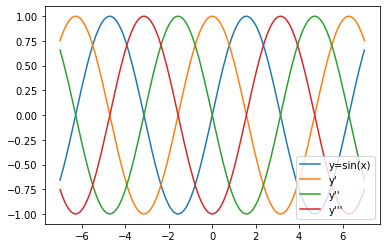

In [20]:
#- step34.sin 함수 고차 미분 

import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

x = Variable(np.linspace(-7, 7, 200)) #- -7 부터 7 까지 균등하게 200 등분한 배열을 생성 
y = F.sin(x) 
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad() #- 미분값 재설정 
    gx.backward(create_graph=True) 
    #- print(x.grad) #- n 차 미분 

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

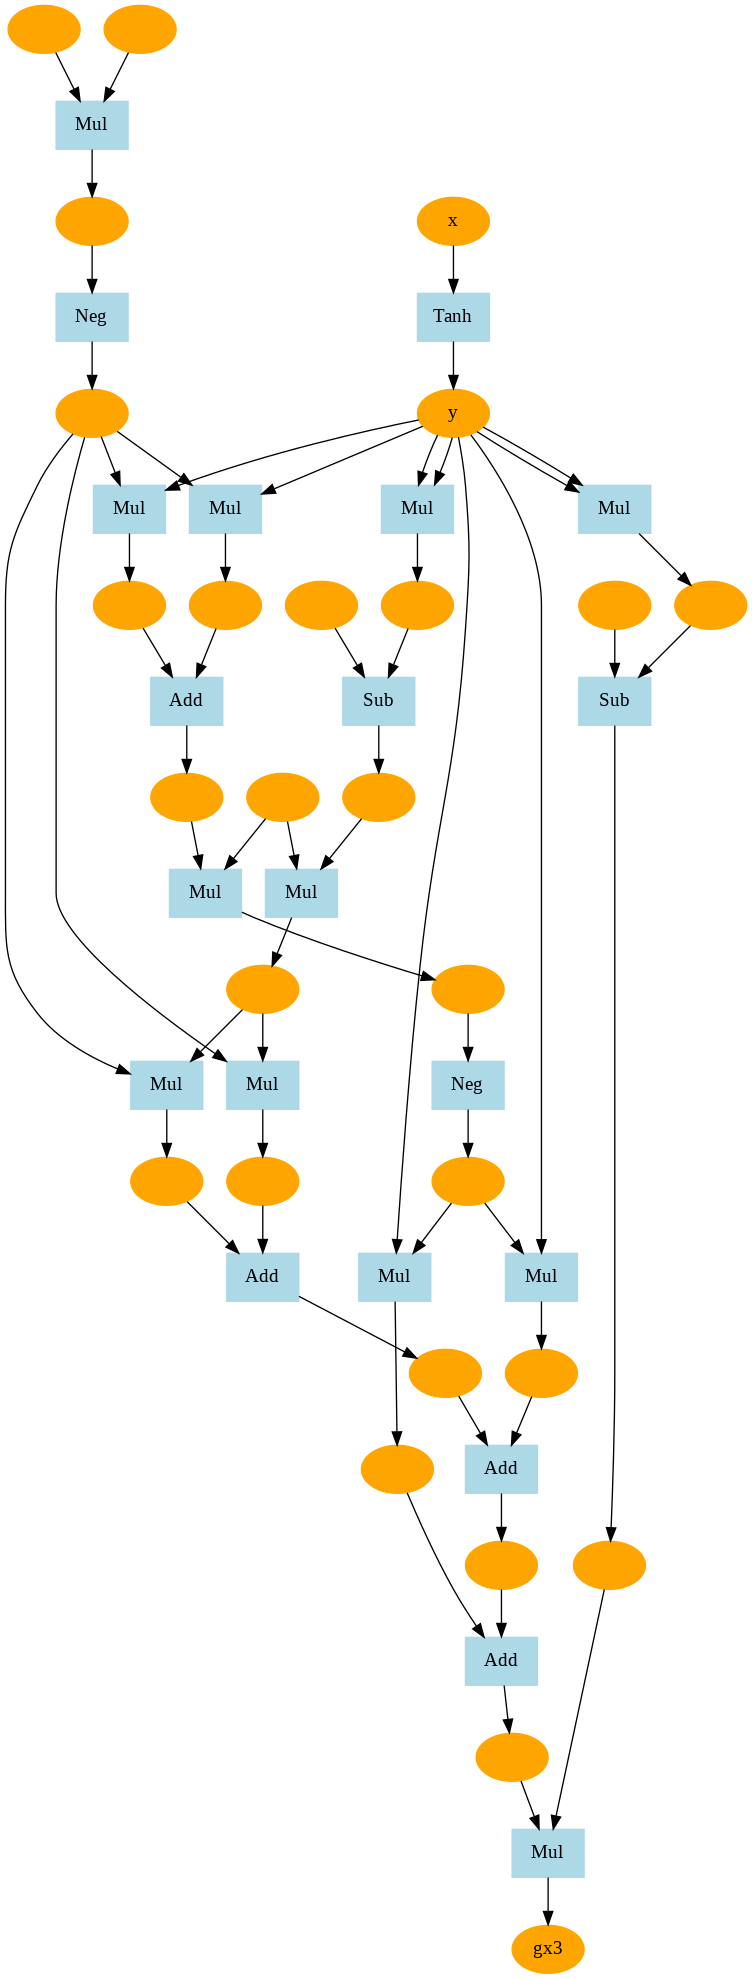

In [22]:
#- step 35. 고차미분 계산그래프
#- tanh, 하이퍼볼릭 탄젠트

from dezero.utils import plot_dot_graph


x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 2

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters + 1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

In [23]:
#- step 36. 고차미분 이외의 용도

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad
x.cleargrad()

z = gx ** 3 + y
z.backward()
print(x.grad)

variable(100.0)
